# **Decision Trees Problem**

### In this workshop, you will explore concepts presented in the tutorial "Problem Solving with Decision Trees," using the dataset related to employee performance and attrition. Specifically, you will carry out the following processes:

 1. Load a dataset.
 2. Prepare the data for modeling.
 3. Data Exploration
 4. Perform hyperparameter tuning for the decision tree model.
 5. Evaluate the best resulting model.

#### **F. J. Ordonez Araujo (fordonezaraujo@gmail.com)**

#### **May 10, 2024 :)**


### Thus, given characteristics in areas such as education, previous jobs, salary, among others, we aim to classify an employee as burned out (with low performance) or not. Before we begin, let's import the necessary libraries:


In [1]:
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score,
                             plot_confusion_matrix, precision_score, recall_score)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

##  **1. Reading data**


In [2]:
df = pd.read_csv("Employee-Attrition.csv")

In [3]:
df.head(6)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,3,80,0,8,2,2,7,7,3,6


In [4]:
# Select columns with categorical data types (e.g., strings) from the DataFrame
categorical_columns = df.select_dtypes(include=['object']).columns

# Count the number of categorical variables in the DataFrame
num_categorical = len(categorical_columns)

print(f"The number of categorical variables: {num_categorical}")



The number of categorical variables: 9


##  **2. Data preparation**


In [5]:
data = df.copy()
# Check the number of missing values in each column of the DataFrame
data.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [6]:
data.duplicated().sum()

0

In [7]:
# Verificar qué columnas contienen valores "Yes" o "No"
columns_with_yes_no = data.columns[data.isin(['Yes', 'No']).any()]

# Replace "Yes" values with 1 and "No" values with 0 in selected columns
data[columns_with_yes_no] = data[columns_with_yes_no].replace({'Yes': 1, 'No': 0})


In [8]:
data.head(6)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
5,32,0,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,3,80,0,8,2,2,7,7,3,6


## **3. Exploratory Data Analysis**

### Adding histograms and box plots to enhance the visual understanding of data distributions. This helps identify any skewness, outliers, or peculiar distributions that may affect model performance.


Text(0.5, 1.0, 'Box Plot of Distance From Home')

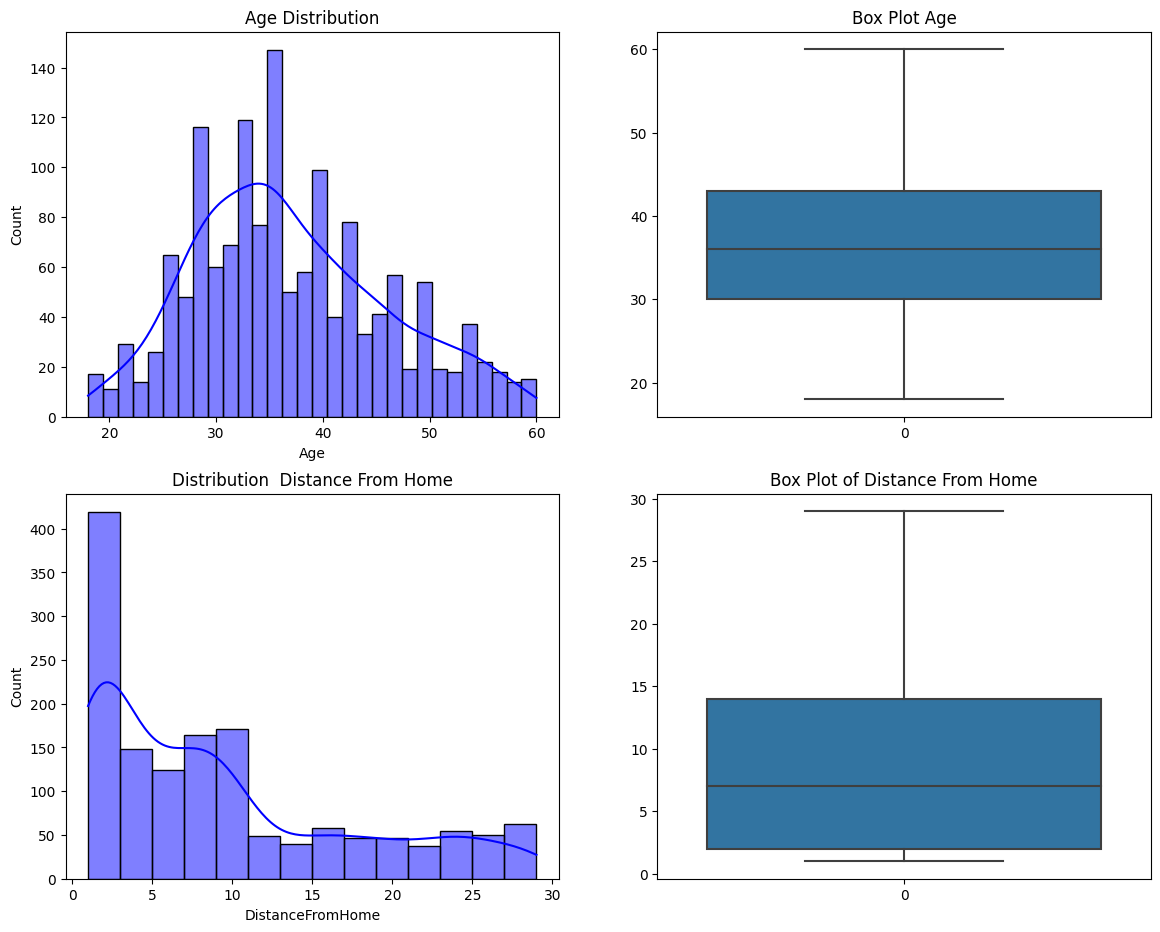

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(14, 11))

# Histograms for the distribution of Ages 
sns.histplot(df['Age'], bins=30, kde=True, color='blue', ax=ax[0,0])
ax[0,0].set_title('Age Distribution')

sns.boxplot(df['Age'], ax=ax[0,1])
ax[0,1].set_title('Box Plot Age')


# Box plot for Distance from Home to visualize outliers which 
# may influence commuting policies or employee satisfaction.
sns.histplot(x=df['DistanceFromHome'], kde=True, color='blue',ax=ax[1,0])
ax[1,0].set_title('Distribution  Distance From Home')


sns.boxplot(df['DistanceFromHome'], ax=ax[1,1])
ax[1,1].set_title('Box Plot of Distance From Home')




## **Correlation Between Variables**

### Generate a heat map of correlation to identify potential relationships among numeric variables like `Age`, `DailyRate`, `DistanceFromHome`, `TotalWorkingYears`.

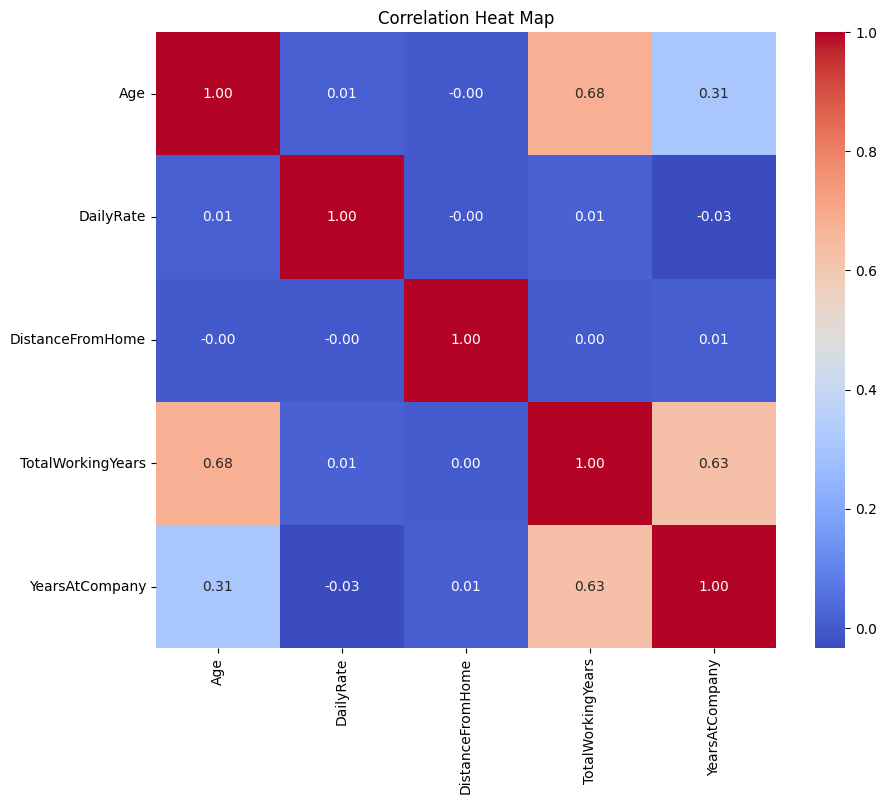

In [46]:
# Select key numerical columns for correlation analysis
cols = ['Age', 'DailyRate', 'DistanceFromHome', 'TotalWorkingYears', 'YearsAtCompany']
# Calculate the correlation matrix
corr_matrix = df[cols].corr()

# Generate a heat map for visual interpretation of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heat Map')
plt.show()


## **Statistical Tests**

### Utilizing statistical tests such as the chi-squared test to validate if categorical variables are independent. This is crucial for understanding interdependencies which could influence model predictions or business decisions.


In [47]:

# Contingency table
contingency_table = pd.crosstab(df['Attrition'], df['Department'])

# Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared Test Statistic: {chi2}")
print(f"P-value: {p}")


Chi-squared Test Statistic: 10.79600732241067
P-value: 0.004525606574479633


###  The results suggest that the department a person works in could be linked to their likelihood of leaving the company. This could be due to various factors specific to those departments, such as work environment, job demands, management style, growth opportunities, etc.

##  **4. Prepare the data for modeling**
First, you will perform the transformation of categorical variables. Use Pandas (`get_dummies` function) to transform 
all categorical variables into numerical variables that can be interpreted by our model.


In [29]:

data = pd.get_dummies(data)
data.head(10)

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y
0,41,1,1102,1,2,1,1,2,94,3,...,0,0,0,0,1,0,0,0,1,1
1,49,0,279,8,1,1,2,3,61,2,...,0,0,0,1,0,0,0,1,0,1
2,37,1,1373,2,2,1,4,4,92,2,...,0,0,0,0,0,0,0,0,1,1
3,33,0,1392,3,4,1,5,4,56,3,...,0,0,0,1,0,0,0,1,0,1
4,27,0,591,2,1,1,7,1,40,3,...,0,0,0,0,0,0,0,1,0,1
5,32,0,1005,2,2,1,8,4,79,3,...,0,0,0,0,0,0,0,0,1,1
6,59,0,1324,3,3,1,10,3,81,4,...,0,0,0,0,0,0,0,1,0,1
7,30,0,1358,24,1,1,11,4,67,3,...,0,0,0,0,0,0,1,0,0,1
8,38,0,216,23,3,1,12,4,44,2,...,0,1,0,0,0,0,0,0,1,1
9,36,0,1299,27,3,1,13,3,94,3,...,0,0,0,0,0,0,0,1,0,1


### Now I must split the dataset into **training** and **testing**. Using 80% of the data for **training** the model and the remaining 20% for **testing** it, use `scikit-learn` to split the dataset into two.

### I selected our independent variable `Attrition` and isolate it in the DataFrame, in this case in y_train, then the dependent variables will be stored in x_train.

In [30]:
train , test = train_test_split(data, test_size= 0.2,  random_state = 0)


x_train = train.drop(['Attrition'],axis=1)
y_train = train["Attrition"]

train.head()
print('x_train_shape:', x_train.shape, 'y_train_shape:', x_train.shape)

x_train_shape: (1176, 54) y_train_shape: (1176, 54)


##  **5. Hyperparameter tuning**



In [31]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

In [32]:
decision_tree = DecisionTreeClassifier(random_state=0)

#### The next step is to define the search space of the hyperparameters. Define a variable named `param_grid` and assign it the expression to create a dictionary with three tuples:


In [33]:
# Define the parameter values for the decision tree
min_samples_split_values = [2, 3, 4, 5, 8, 9, 10]
max_depth_values = [2, 3, 4, 5,  6, 8]
criterion_values = ['entropy', 'gini']

# Define the parameter grid
param_grid = {
    "criterion": criterion_values,
    "max_depth": max_depth_values,
    "min_samples_split": min_samples_split_values
}


In [34]:
# Set up the grid search with the decision tree model, using the defined parameter grid
# Specify 'accuracy' as the scoring method and use k-fold cross-validation
grid = GridSearchCV(decision_tree, param_grid, scoring='accuracy', cv= kfold, n_jobs=3)

# Fit the grid search to the training data to find the best model parameters
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=3,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [2, 3, 4, 5, 6, 8],
                         'min_samples_split': [2, 3, 4, 5, 8, 9, 10]},
             scoring='accuracy')

In [35]:
print("Best parameters: {}".format(grid.best_params_))

best_model = grid.best_estimator_

Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}


In [36]:
# Extract feature importances from the best model obtained from the grid search
importance = best_model.feature_importances_
# Create a DataFrame to hold the feature names and their corresponding importance
importance_df = pd.DataFrame(data={'Variable': x_train.columns, 'Importance': importance})
# Sort the DataFrame by the importance of the features in descending order
importance_df.sort_values('Importance', ascending=False).head(7)

,Variable,Importance
11,MonthlyIncome,0.306294
14,OverTime,0.271915
23,YearsAtCompany,0.115569
48,JobRole_Sales Executive,0.090559
19,StockOptionLevel,0.084785
0,Age,0.072370
20,TotalWorkingYears,0.058509


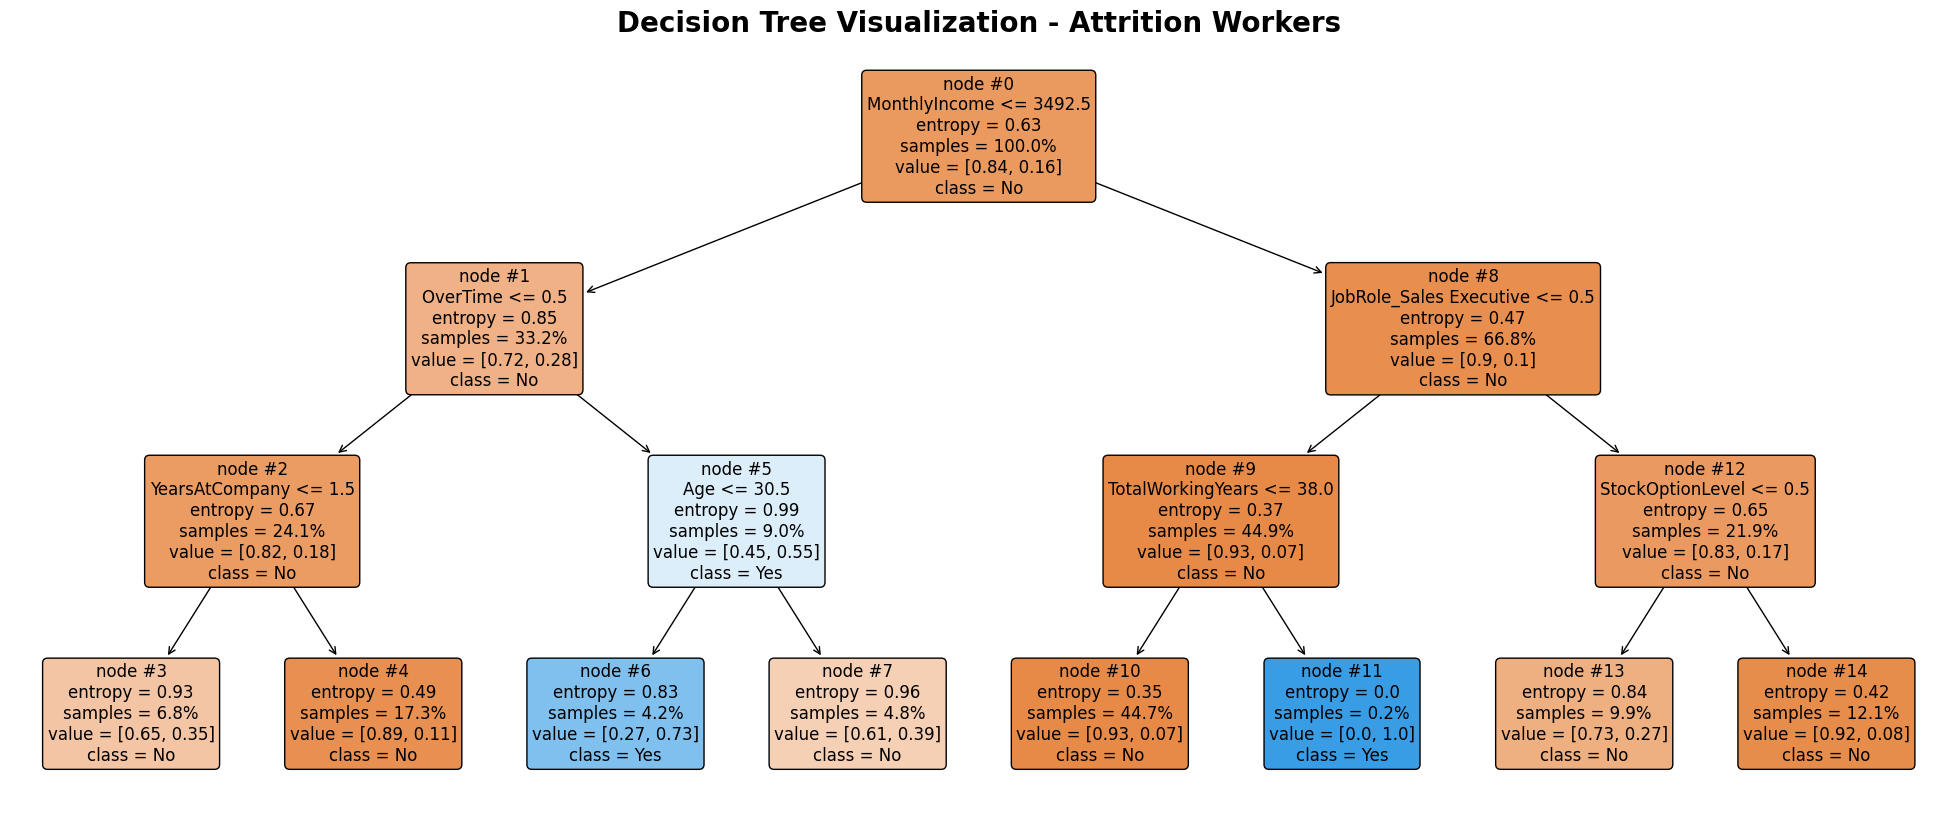

In [42]:
plt.figure(figsize=(25, 10))

# Plot the decision tree
tree = plot_tree(best_model, 
                 feature_names=x_train.columns, 
                 class_names=['No', 'Yes'], 
                 filled=True, 
                 fontsize=12,  # Adjust fontsize for better readability
                 node_ids=True,  # Optionally, you can show node IDs
                 proportion=True,  # Shows the proportion of each class in the nodes
                 rounded=True,  # Rounded corners for the nodes
                 precision=2,  # Precision of the numbers in the nodes
                 )  # Use bold font for better visibility

# Add a title to the plot
plt.title('Decision Tree Visualization - Attrition Workers', fontsize=20, fontweight='bold')

# Show the plot
plt.show()


## **6. Evaluate the best resulting model**


### Separate the independent variables and the target variable in the test dataset. To do this, use Pandas to create two variables, `x_test` and `y_test`, which will store the independent variables and the target variable, respectively.

In [38]:
x_test = test.drop(["Attrition"], axis=1)
y_test = test["Attrition"]

In [39]:
# Use the best model to predict the target variable based on the independent variables in the test set
y_pred = best_model.predict(x_test)

# Calculate the confusion matrix to evaluate the accuracy of the predictions against the actual values
p43 = confusion_matrix(y_test, y_pred)
p43

array([[240,   5],
       [ 40,   9]])

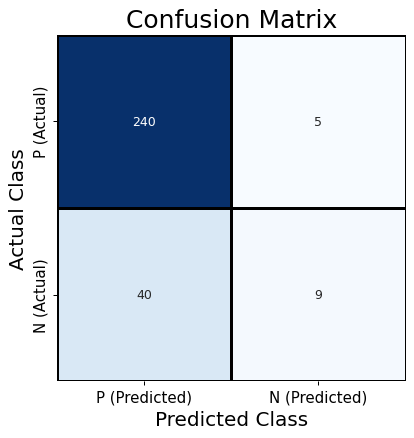

In [40]:
# Define class labels for the matrix
class_labels = ['P', 'N']

# Create a pandas DataFrame for the confusion matrix with row and column labels
p43_df = pd.DataFrame(p43, index=['P (Actual)', 'N (Actual)'], columns=['P (Predicted)', 'N (Predicted)'])

# Create a heatmap for the confusion matrix for better visual interpretation
plt.figure(figsize=(5, 5), dpi=90)
heatmap = sns.heatmap(p43_df, annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor='black', cbar=False)

# Add labels and a title
plt.title('Confusion Matrix', fontsize=20)
plt.ylabel('Actual Class'   , fontsize=16)
plt.xlabel('Predicted Class', fontsize=16)

plt.xticks(fontsize=12)  # Set x-axis tick labels size
plt.yticks(fontsize=12)
# Show the plot
plt.show()


In [41]:
# Calculate the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud: ", accuracy)


# Calculate the recall of the model on the test data, which measures the ability to find all the relevant cases (true positives)
recall =recall_score(y_test, y_pred)
print("Sensibilidad: ", recall)

# Calculate the F1 score of the model on the test data
f1_result = f1_score(y_test, y_pred)  # Rename the variable to avoid conflict with the function name
print('F1-Score: ', f1_result)


Exactitud:  0.8469387755102041
Sensibilidad:  0.1836734693877551
F1-Score:  0.28571428571428575
